# Overview


<span class = "myhighlight">Objective.</span>
The following project involves extracting and analyzing Spotify data from top playlists using the Spotify and Genius Lyrics Web API. Natural Language Processing techniques are used to process lyrics and perform sentiment analysis. K-means clustering and PCA analysis are employed to categorize songs and analyze relationships between musical features.



In [1]:
import pandas as pd
from bioinfokit.visuz import cluster
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import transformers
from IPython.core.display import HTML
from IPython.display import set_matplotlib_formats
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
from functools import partial
from rpy2.ipython import html
from rpy2.robjects.packages import importr
html.html_rdataframe=partial(html.html_rdataframe, table_class="docutils")
import warnings # Hide warnings if there are any
warnings.filterwarnings('ignore')

# Import Data
all_tracks = pd.read_csv("assets/data/all_tracks.csv", index_col=False)
all_tracks_with_lyrics = pd.read_csv("assets/data/all_tracks+lyrics.csv", index_col=False)

C:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



C:\Python311\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning:

The symbol 'quartz' is not in this R namespace/package.



In [2]:
## Set Default Plot Chart Style Configurations
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = (8, 5) # Set default figure size.
plt.rc('font', family='Roboto') # Set default font family

pd.set_option('display.max_colwidth', None)
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=.5, rc={"grid.linewidth": 0.6})
sns.set_style({'font.family': 'Roboto'})

%load_ext rpy2.ipython 
%R require(ggplot2)
%R require(hrbrthemes)
%R require(patchwork)
%R require(ragg)

Loading required package: ggplot2
In addition: Warning message:
package 'ggplot2' was built under R version 4.1.3 


Loading required package: hrbrthemes
Registering Windows fonts with R
In addition: Warning message:
package 'hrbrthemes' was built under R version 4.1.3 


Loading required package: patchwork


Loading required package: ragg
In addition: Warning message:
package 'ragg' was built under R version 4.1.3 


## Extracting Spotify Data

Getting started, we want to extract data for a set of tracks within one of Spotify's top-featured playlists. Leveraging the **Spotify Web API**, we can seamlessly obtain detailed data for a song, such as the artist, the album it belongs to, its release date, popularity, and audio features like danceability, energy, and tempo. 


### Accessing the Spotify Web API

Python libraries like `spotipy` offer a user-friendly way to interact with the Spotify API, offering a range of functions that streamline tasks like API authentication. To authenticate access, we provide a client ID and secret. Once authenticated, we can interact with the API and retrieve data.


In [3]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

my_auth = SpotifyClientCredentials(client_id = "xxx", client_secret = "xxx")
sp = spotipy.Spotify(auth_manager=my_auth)  # Spotify authentication

In [4]:
client_id = "3899576b5fcb4c458beba2cce99aa1b6"
client_secret = "4f57df7614df4f75b54364bf3c3018fd"
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id, client_secret))

#### Spotify's Featured Playlists

Let's take a look at the popular Spotify playlists. Below, the code retrieves a range of Spotify playlists and generates a dataframe containing details for each playlist.

In [5]:
username = "spotify"
my_playlists = sp.user_playlists(username)

In [6]:
playlist_df = []
# Loop through list of response dictionaries
for item in my_playlists["items"]:
    playlist_id = item["id"]
    playlist_name = item["name"]
    description = item["description"]
    thumbnail = item["images"][0]["url"]
    total = item["tracks"]["total"]
    playlist_df.append([thumbnail, playlist_name, playlist_id, description, total])

playlist_df = pd.DataFrame(playlist_df, columns=["thumbnail", "playlist_name", "playlist_id", "description", "total"], ).head(3)

# Converting links to html tags
def path_to_image_html(path):
    return f'<img src="{path}" width="40" >'

# Rendering the dataframe as HTML table
HTML(playlist_df.to_html(escape=False, formatters=dict(thumbnail=path_to_image_html)))

,thumbnail,playlist_name,playlist_id,description,total
0,,Today’s Top Hits,37i9dQZF1DXcBWIGoYBM5M,Karol G is on top of the Hottest 50!,50
1,,RapCaviar,37i9dQZF1DX0XUsuxWHRQd,"New music from Eminem, Ice Spice and BossMan DLow.",50
2,,Hot Country,37i9dQZF1DX1lVhptIYRda,Today's top country hits. Cover: Megan Moroney,50


---------------------

### Extracting Track Data From Playlist

Next, we utilize Spotify's API to extract further details about each song within the playlist. We obtain metadata such as the track name, the artist it's sung by, the album it belongs to, the release date, and track features such as danceability, tempo, and popularity.

In [7]:
def get_playlist_tracks(playlist_URI):
    results = sp.playlist_tracks(playlist_URI)
    tracks = results["items"]
    while results["next"]:
        results = sp.next(results)
        tracks.extend(results["items"])
    return tracks

Choose a specific playlist to analyze by copying the URL from the Spotify Player interface. Using that link, the `playlist_tracks` method retrieves a list of IDs and corresponding artists for each track from the playlist. Specifically, we analyze Spotify's *Today’s Top Hits* playlist.

In [8]:
all_tracks = all_tracks[['name', 'track_id', 'album', 'artist', 'artist_id', 'release_date',
       'length', 'popularity', 'artist_pop', 'artist_genres',
       'artist_followers', 'acousticness', 'danceability', 'energy', 'instrumentalness', 
       'liveness', 'loudness', 'loudness_scaled', 'speechiness', 'tempo',
       'valence', 'key', 'mode', 'time_signature', 'playlist']]

In [9]:
# Count distinct values in column
tallyArtists = all_tracks.value_counts(["artist", "artist_id"]).reset_index(name='counts')
topArtist = tallyArtists['artist_id'][1]

tallyArtistPop = all_tracks.value_counts(["artist_pop"]).reset_index(name='counts')
tallyPop = all_tracks.value_counts(["popularity"]).reset_index(name='counts')
tallyPop = tallyPop[tallyPop['popularity'] > 0]

<iframe width="102%" height="350px" src="./01_sentiment_analysis/genres_plot.html" frameborder="0" allowfullscreen="" style="margin-bottom: -5px;"></iframe>
<iframe width="100%" height="290px" src="./01_sentiment_analysis/html/track_features.html" frameborder="0" allowfullscreen="" style="margin-bottom: 0px;"></iframe>

In [10]:
links_dict = {"source_name":[],"source_id":[],"target_name":[],"target_id":[]};

for id, name in tallyArtists[["artist_id","artist"]].values:
    ra = sp.artist_related_artists(id)
    for artist in ra['artists']:
        links_dict["source_name"].append(name)
        links_dict["source_id"].append(id)
        links_dict["target_name"].append(artist['name'])
        links_dict["target_id"].append(artist['id'])

links_dict_df = pd.DataFrame(links_dict)
#links_dict_df.to_csv("assets/data/artist_nodes.csv", index=False)

-------


## Natural Language Processing

Using the data gathered from the Spotify API, we now want to extract and process lyrics for each song. This is accomplished through scraping textual lyrical data from the **Genius Lyrics** website. Following extraction, the lyrics are cleaned before undergoing sentiment analysis.







### Scraping Song Lyrics

The `lyricsgenius` is a fundamental library allowing for web scraping of the Genius Lyrics website. Through the initialization of the `genius` variable, one can access the Genius API and retrieve the lyrics of any given song, such as "Too Many Nights" by Metro Boomin.



In [11]:
access_token = "epFCxujgBe-Y6WrkZedI8kerKxiCpR6Rh0DAHYNlKDf9B4H1nXTdZIkj7krNUHVV"

In [12]:
import lyricsgenius
genius = lyricsgenius.Genius(access_token) # Initialize Genius API
song = genius.search_song("Too Many Nights", "Metro Boomin")

Searching for "Too Many Nights" by Metro Boomin...


Done.


### Pre-Processing Text Data

Using the genius library, we define a function to fetch the lyrics of a song given the name and artist. Once retrieved, the next step is to pre-process the lyrics. This involves a cleaning process to eliminate patterns that may hinder the overall readability. The script contains the following steps:

<div class = "roundedlist">

1. Fetching Track Lyrics
2. Expanding Contractions
3. Converting Text to Lowercase
4. Spell Checking + Censoring
5. Removing Punctuations
6. Tokenizing and encoding to ASCII

</div>

<!-- Overall, the `clean_song_lyrics` function extracts lyrics from Genius database, expands contractions, removes repetitive phrases, corrects spelling, eliminates profanity, and returns tokenized lyrics as a list of words.-->

In [13]:
def clean_song_lyrics(song_name, artist_name):
    # Fetch song lyrics and clean
    lyrics = get_song_lyrics(song_name, artist_name) 
    lyrics = profanity.censor(contractions.fix(lyrics).lower(), censor_char="")
    lyrics = remove_punctuation(lyrics) 
    
    # Tokenizing and encoding to ASCII
    return [word.encode("ascii", "ignore").decode() for word in word_tokenize(lyrics)]

#### Further Text Cleaning

We employ the Natural Language Toolkit (*NLTK*) to filter out stopwords and perform lemmatization. Removing common words like "the" condenses the text, allowing for a more thorough analysis of the lyrics' core message. Lemmatization helps standardize text by transforming different verb variations into their most basic form. 


In [14]:
pd.options.display.max_colwidth = 55
df_lyrics = all_tracks_with_lyrics[['name',  'artist', 'lyrics', 'stopwords_removed', 'lemmatized']]
df_lyrics.head(3)

,name,artist,lyrics,stopwords_removed,lemmatized
0,Please Please Please,Sabrina Carpenter,"['i', 'know', 'i', 'have', 'good', 'judgment', 'i',...","['know', 'good', 'judgment', 'know', 'good', 'taste...","['know', 'good', 'judgment', 'know', 'good', 'taste..."
1,Si Antes Te Hubiera Conocido,KAROL G,"['what', 'what', 'we', 'are', 'in', 'a', 'relay', '...","['relay', 'summer', 'started', 'fire', 'would', 'me...","['relay', 'summer', 'start', 'fire', 'would', 'meet..."
2,BIRDS OF A FEATHER,Billie Eilish,"['i', 'want', 'you', 'to', 'stay', 'til', 'i', 'am'...","['want', 'stay', 'til', 'grave', 'til', 'rot', 'awa...","['want', 'stay', 'til', 'grave', 'til', 'rot', 'awa..."


#### Term Frequency Analysis

<!-- Exploratory text analysis-->

Let's examine the most frequent words. Plotting the frequency distribution helps to determine the occurrence of the most common terms in our lyrical corpus.

In [15]:
from nltk.probability import FreqDist

all_words = []
for words in df_lyrics['lemmatized']:
    res = words.replace("'", "").strip('][').split(', ')
    all_words += res

mostcommon = FreqDist(all_words).most_common(30)
x_mostcommon, y_mostcommon = zip(*mostcommon)


<iframe width="100%" height="360px" src="./01_sentiment_analysis/html/lyrics.html" frameborder="0" allowfullscreen="" style="margin-bottom: -5px;"></iframe>


--------------


## Sentiment Analysis

The next process involves implementing pipelines to predict emotions and sentiment in textual content using transformer models designed for text classification and sentiment analysis. Three distinct pipelines are created, each equipped with different models.


In [16]:
from transformers import pipeline

classifiers = [ # Initialize sentiment classifiers
    pipeline(model='bhadresh-savani/distilbert-base-uncased-emotion'),
    pipeline(model='cardiffnlp/twitter-roberta-base-sentiment')
]

One of the classifiers is the *distilbert-base-uncased-emotion* model, which detects emotions in texts like sadness, joy, love, anger, fear, and surprise. Another classifier is the *roBERTa-base* model "trained on 58 million tweets and fine-tuned for sentiment analysis using the TweetEval benchmark" (EMNLP 2020). 

We then implement the `get_lyric_sentiment` function, which uses three classifiers to calculate sentiment scores from pre-processed lyrics. 

In [17]:
# Function to perform sentiment analysis
def get_lyric_sentiment(lyrics, classifiers):
    text = " ".join(lyrics)
    scores = {}
    for classifier in classifiers:
        try:
            predictions = classifier(text, truncation=True)
            for prediction in predictions[0]:
                scores[prediction["label"]] = prediction["score"]
        except Exception as e:
            print(f"Error during sentiment analysis: {e}")
    return scores

Below is a graphical representation of the results obtained from the *roBERTa-base* model. According to the **TweetEval** reference paper and official Github repository, the resulting labels `0`, `1`, and `2` correspond to Negative, Neutral, and Positive, respectively.


<iframe width="100%" height="200px" src="./01_sentiment_analysis/html/roBERTa.html" frameborder="0" allowfullscreen="" style="margin-bottom: 0px;"></iframe>


---------------------


## Putting it All Together


To summarize, the code efficiently collects data and performs text analysis on every song in a playlist. Specifically, it systematically processes a list of tracks and corresponding artists while simultaneously conducting a thorough cleaning procedure on the lyrics. Additionally, the program computes a sentiment score for each song based on the lyrics, indicating whether the lyrics are positive, negative, or neutral. 


In [18]:
# all_tracks_with_lyrics.head(2)
df_final = all_tracks_with_lyrics[['name', 'album', 'artist', 'release_date',
       'length', 'popularity', 'artist_pop', 'artist_genres', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness','loudness_scaled',
       'speechiness', 'tempo', 'valence', 'key', 'mode', 'time_signature',
       'playlist', 'sadness', 'joy', 'love', 'anger', 'fear', 'surprise',
       'LABEL_0', 'LABEL_1', 'LABEL_2', 'NEGATIVE', 'POSITIVE']]

df_final.head(3)

,name,album,artist,release_date,length,popularity,artist_pop,artist_genres,acousticness,danceability,...,joy,love,anger,fear,surprise,LABEL_0,LABEL_1,LABEL_2,NEGATIVE,POSITIVE
0,Please Please Please,Please Please Please,Sabrina Carpenter,2024-06-06,186365,98,91,['pop'],0.274,0.669,...,0.955393,0.035888,0.002778,0.000637,0.000841,0.251058,0.542962,0.205980,0.857851,0.142149
1,Si Antes Te Hubiera Conocido,Si Antes Te Hubiera Conocido,KAROL G,2024-06-21,195824,91,89,"['reggaeton', 'reggaeton colombiano', 'trap latino'...",0.446,0.924,...,0.003352,0.008062,0.982214,0.002481,0.000541,0.043676,0.469266,0.487059,0.957238,0.042762
2,BIRDS OF A FEATHER,HIT ME HARD AND SOFT,Billie Eilish,2024-05-17,210373,98,94,"['art pop', 'pop']",0.200,0.747,...,0.180090,0.008181,0.068175,0.434426,0.034063,0.122799,0.504202,0.372999,0.959893,0.040107


In summary, the above code aims to collect and refine song lyrics by eliminating stopwords and conducting lemmatization. Subsequently, it employs pre-trained models for sentiment analysis to determine the prevailing emotion conveyed in the lyrics. Finally, the program compiles all this information into a dataframe for further analysis.


------------------------------------


## Correlations Matrix

After completing the initial data analysis, we proceed with generating the Pearson correlations matrix using the Pandas command `df.corr()`. Subsequently, we visualize the matrix using the seaborn heatmap, providing a detailed understanding of the relationships between the various variables in our dataset.


In [19]:
track_sentiment_df = df_final[['name', 'artist',
           'acousticness', 'danceability', 'energy', 'instrumentalness', 
           'loudness', 'speechiness', 'tempo', 'valence', 
           'sadness', 'joy', 'love', 'anger', 'fear', 'surprise',
           'LABEL_0', 'LABEL_1', 'LABEL_2', 'NEGATIVE', 'POSITIVE']]

# Find the pearson correlations matrix
corr = track_sentiment_df.corr(method = 'pearson')

<iframe width="100%" height="450px" src="./01_sentiment_analysis/html/corr.html" frameborder="0" allowfullscreen="" style="margin-bottom: -5px;"></iframe>


The code below produces a scatterplot that showcases the correlation between energy and fear. The x-axis represents the energy value, while the y-axis represents the fear sentiment. The size of each data point corresponds to the label indicating the neutral sentiment level, and its color represents the valence value. Moreover, each bubble contains its energy value within, allowing for a straightforward interpretation of the data.


<iframe width="100%" height="340px" src="./01_sentiment_analysis/html/corr_bubble1.html" frameborder="0" allowfullscreen="" style="margin-bottom: -5px;"></iframe>


Similarly, the scatterplot presented above utilizes the track sentiment data, comparing the energy and fear levels of the tracks based on valence and size.

------



## Principal Component Analysis

Principal Component Analysis (PCA) is a **unsupervised** dimension reduction algorithm. We implement PCA on a range of track audio features as well as emotional sentiments such as sadness, joy, love, anger, and more from our data. This lets us transform the data into fewer columns, reducing the dimensionality without losing significant information.


After performing PCA on the data, we apply it to generate a biplot depicting the relationship between the features and tracks. This biplot quickly reveals any discernible patterns and clusters within the dataset.


In [20]:
X_SMALL = df_final[['acousticness', 'danceability', 'energy', 'speechiness', 
                    'tempo', 'valence', 'sadness', 'joy', 'love', 'anger', 
                    'fear', 'surprise', 'name', 'LABEL_0', 'LABEL_1', 'LABEL_2']]



We use the `PCA` and `StandardScaler` modules from the `sklearn` library. First, we select the first 12 columns from our data subset and form a matrix, named $X_i$. We then standardize the data. Next, we apply PCA to the standardized data, $X_{st}$. Lastly, we save the obtained loadings and eigenvalues.




In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standard scaling track audio features
X_i = X_SMALL.iloc[:,0:12]
X_st =  StandardScaler().fit_transform(X_i)

# Apply PCA to scaled data
pca = PCA()
pca_out = pca.fit(X_st)

# component loadings
loadings = pca_out.components_

# get eigenvalues (variance explained by each PC)  
pca_out.explained_variance_

array([2.65011368e+00, 1.78220617e+00, 1.32078217e+00, 1.23927771e+00,
       1.13536483e+00, 1.04777115e+00, 8.75900205e-01, 7.54116010e-01,
       6.06658820e-01, 5.67131303e-01, 2.65575917e-01, 7.98632974e-15])

Next, the following code uses the `PCA()` function to calculate the PCA scores of the standardized data set, $X_{st}$. 

In [22]:
target = X_SMALL['name'].to_numpy()

In [23]:
features = X_i.columns.values # Labels
components = pca.fit_transform(X_st) # PCA Score
loadings = pca_out.components_.T * np.sqrt(pca_out.explained_variance_)

A biplot is generated based on the PCA scores and loadings, and the column names of the $X_i$ data frame are used as labels for the plot. The variance explained by the first two principal components are also displayed on the plot.


In [24]:
from numpy import size

my_color_pal3 = ["#6941FA", "#8F51ED", "#A951E0"]
my_color_pal3 = ["#A951E0", "#D0B6F7", "#6941FA"]

fig = px.scatter(components, labels=X_i.columns.values, x=2, y=10, 
                 template="ggplot2+plotly_white", color=0, 
                 color_continuous_scale=my_color_pal3,
                 width=800, height=400)

for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0, 
        axref="x", ayref="y",
        x=loadings[i, 0], 
        y=loadings[i, 1],
        showarrow=True, 
        arrowsize=2, 
        arrowhead=2,
        xanchor="right", 
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0], 
        y=loadings[i, 1], 
        ax=0, ay=0,
        xanchor="center", 
        yanchor="bottom", 
        text=feature, 
        yshift=5,
    )

text1 = f"PC2 ({str(round(pca_out.explained_variance_ratio_[2] * 100, 2))}%)"
text2 = f"PC10 ({str(round(pca_out.explained_variance_ratio_[10] * 100, 2))}%)"

fig.update_layout(font_family="Roboto", font_size=13, 
                  margin=dict(r=10, t=50, b=50, l=10),
                  title=dict(
                      text='<b>Figure 7.</b> Principal Component Analysis Biplot', 
                      font=dict(size=13, family="Roboto Condensed"), 
                          automargin=True, yref='paper',xref='paper'),
               xaxis=dict(title=text1,gridcolor='#eeeeee', gridwidth=1,title_font_family="Roboto Condensed",
                          title_font_size=13, title_font_color="black"),
               yaxis=dict(title=text2, gridcolor='#eeeeee', gridwidth=1,title_font_family="Roboto Condensed",
                          title_font_size=13, title_font_color="black"),
)


#fig.update_xaxes(range=[-2, 2.5])
fig.update_traces(marker_size=7.5)

#fig.update_layout(coloraxis_showscale=False)
fig.update_layout(coloraxis_colorbar=dict(
    title="PC0",thickness=5,
     lenmode="pixels",title_font_size=13,dtick = 1,title_font_family="Roboto Condensed"
    
    
    
))

#fig.write_html("html/pca.html")

fig.show()

Below is a preview of all the PCA clustered groups.

In [25]:
pca_scores = PCA().fit_transform(X_st)
cols_pca = [f'PC{i}' for i in range(1, pca_out.n_components_+1)]
df_pca = pd.DataFrame(pca_scores, columns=cols_pca, index=X_i.index)

df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,-0.652941,-0.540595,0.277601,-1.276863,0.412919,-0.207641,-0.019832,0.451893,-0.773699,-0.432625,0.148075,-1.635591e-08
1,-1.192109,3.319574,-0.687571,1.032594,0.775812,-0.537727,-1.541805,-0.796704,-0.756995,0.949406,-0.429861,8.099381e-08
2,1.080397,0.204470,1.129465,-0.305987,0.566007,0.881001,-0.641871,0.360368,0.671404,0.286174,-0.287698,-1.186518e-07
3,-1.306320,-0.990882,0.597186,-1.050503,0.141820,-0.638868,-0.483447,0.085446,0.096276,0.019933,0.731528,7.415103e-09
4,-1.335645,-1.277782,-0.085476,-1.018065,0.395467,0.719844,-0.612023,0.245817,-0.426194,0.805717,0.072715,-9.832706e-08


The variance ratios for the PCA output and the cumulative sum of the explained variance ratios are printed below. Specifically, the array displayed represents the amount of variability explained by each component.

In [26]:
print(pca_out.explained_variance_ratio_)
print('----')
print(pca_out.explained_variance_ratio_.cumsum())

[2.16425951e-01 1.45546837e-01 1.07863877e-01 1.01207680e-01
 9.27214608e-02 8.55679769e-02 7.15318501e-02 6.15861408e-02
 4.95438036e-02 4.63157231e-02 2.16886999e-02 6.52216928e-16]
----
[0.21642595 0.36197279 0.46983667 0.57104434 0.66376581 0.74933378
 0.82086563 0.88245177 0.93199558 0.9783113  1.         1.        ]



The loading vectors help visualize the relationship between the original variables and their respective components. These vectors represent the weights of the variables within a mathematical equation used to generate the principal components.

In [27]:
df_weights = pd.DataFrame(pca_out.components_.T, columns=df_pca.columns, index=X_i.columns)
df_weights

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
acousticness,0.253094,0.425560,-0.081137,-0.051999,0.120657,-0.270423,0.038467,0.565513,-0.512979,-0.059977,-0.264270,-2.786806e-08
danceability,-0.428916,0.327036,-0.026959,-0.109895,0.101021,0.030147,-0.217469,0.138922,0.523550,-0.012503,-0.586779,4.801649e-10
energy,-0.309072,-0.169597,-0.250304,0.309696,-0.430665,0.106693,0.308849,0.025428,-0.270576,0.482465,-0.343909,-2.016976e-08
speechiness,-0.188700,0.395047,-0.062115,-0.032742,-0.118204,0.304929,0.670314,-0.052322,0.033915,-0.472329,0.141921,6.140892e-09
tempo,0.102180,0.112419,0.250471,0.222759,-0.388726,-0.698286,0.097755,-0.348045,0.104721,-0.220550,-0.188555,9.069694e-09
valence,-0.437115,0.155936,0.052694,0.248609,-0.017721,-0.338282,-0.003064,0.417016,0.182694,0.208423,0.595445,-1.736405e-08
sadness,0.396350,0.061848,-0.457667,-0.064144,-0.420210,0.034624,-0.077819,0.190498,0.359314,0.010301,0.101546,5.156194e-01
joy,-0.412556,-0.266452,0.186634,-0.496523,-0.074336,-0.157048,0.007957,0.032509,-0.274236,-0.148999,-0.020153,5.901792e-01
love,-0.030564,-0.320082,-0.212120,0.566633,0.503138,-0.097366,0.140785,0.062050,0.057297,-0.303900,-0.150700,3.548201e-01
anger,-0.128199,0.542932,-0.134174,0.206550,0.133607,0.089812,-0.313582,-0.502087,-0.289683,0.161095,0.126852,3.547164e-01


------------------------------

## K Means Clustering


> Clustering is an unsupervised machine learning technique used to categorize data points into distinct groups based on their similarities. In Spotify data, for example, clustering can categorize songs into genres or moods by analyzing characteristics like tempo, beat, and instrumentals. 


Next, we apply K-means clustering on the dimensionally reduced Spotify data to explore patterns in track audio features and sentiment. K-means is an unsupervised algorithm that optimizes the number of clusters ($K$). We use the Elbow method to determine the optimal $K$.


As shown below, we use the KMeans algorithm from the *sklearn.cluster* library to categorize songs based on features like energy levels and sound qualities. Applying this to the "playlist_tracks" dataset, we create three [clusters](https://github.com/ankushbharadwaj/reorganize-my-spotify-playlist/blob/master/reorder%20my%20spotify%20playlist.ipynb), excluding the "artist" and "name" columns to focus on track features.



In [28]:
from sklearn.cluster import KMeans
playlist_tracks = df_final[['name','acousticness','danceability','energy', 'liveness', 
                            'instrumentalness','speechiness','valence',
                            'sadness', 'joy', 'love', 'anger', 'fear', ]]#'surprise'

kmeans = KMeans(n_clusters = 3)
kmeans.fit(playlist_tracks.drop(['name'], axis = 1))

KMeans(n_clusters=3)

In [29]:
x=[str(group) for group in kmeans.labels_]
#sns.countplot(x=[str(group) for group in kmeans.labels_], color = 'lightblue')

fig = go.Figure()
fig.add_trace(
    go.Histogram(histfunc="count", x=x, 
                 marker=dict(color="#EDB3F8"), showlegend=False,
                 textfont={"family": "Roboto", "size": 12, "color": "black"})
)

fig.update_layout(
    xaxis=dict(title='Count',titlefont_size=12,tickfont_size=14),
    yaxis=dict(tickfont_size=13),
    barmode="group",
    bargap=0.125,  # gap between bars of adjacent location coordinates.
    bargroupgap=0.1,  # gap between bars of the same location coordinate.
    template="plotly_white",
    font_family = "Roboto Condensed",
    #margin=dict(r=10, t=5, b=5, l=90),
    title=dict(text='<b>Figure 8.</b> KMeans Clustering (n_clusters=3)', 
               font=dict(size=15, family="Roboto Condensed"), automargin=True) #yref='paper'
    )

fig.update_traces(marker_color= '#6A8559', 
                  marker_line_color='#4E6241',
                  marker_line_width=1.5, opacity=0.996,
                  textfont_size=18, textangle=0, cliponaxis=False,textposition="outside")

fig.update_xaxes(title_standoff = 1,
                 title_font=dict(size=11, family='Roboto Condensed', color='black'),
                 tickfont=dict(family='Roboto', color='black', size=10))

fig.update_yaxes(tickfont=dict(family='Roboto', color='black', size=12))
#fig.write_html("html/lyrics.html")

fig.show()


#### Visualizing the Clusters


Moving forward, let's look at differences in the audio features of each group.



In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(playlist_tracks.drop(['name'], axis = 1))
scaled_data = scaler.transform(playlist_tracks.drop(['name'], axis = 1))

In [31]:
#| code-fold: true

from sklearn.decomposition import PCA
pca = PCA(n_components =2)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)

Text(0, 0.5, 'PC2: 0.153')

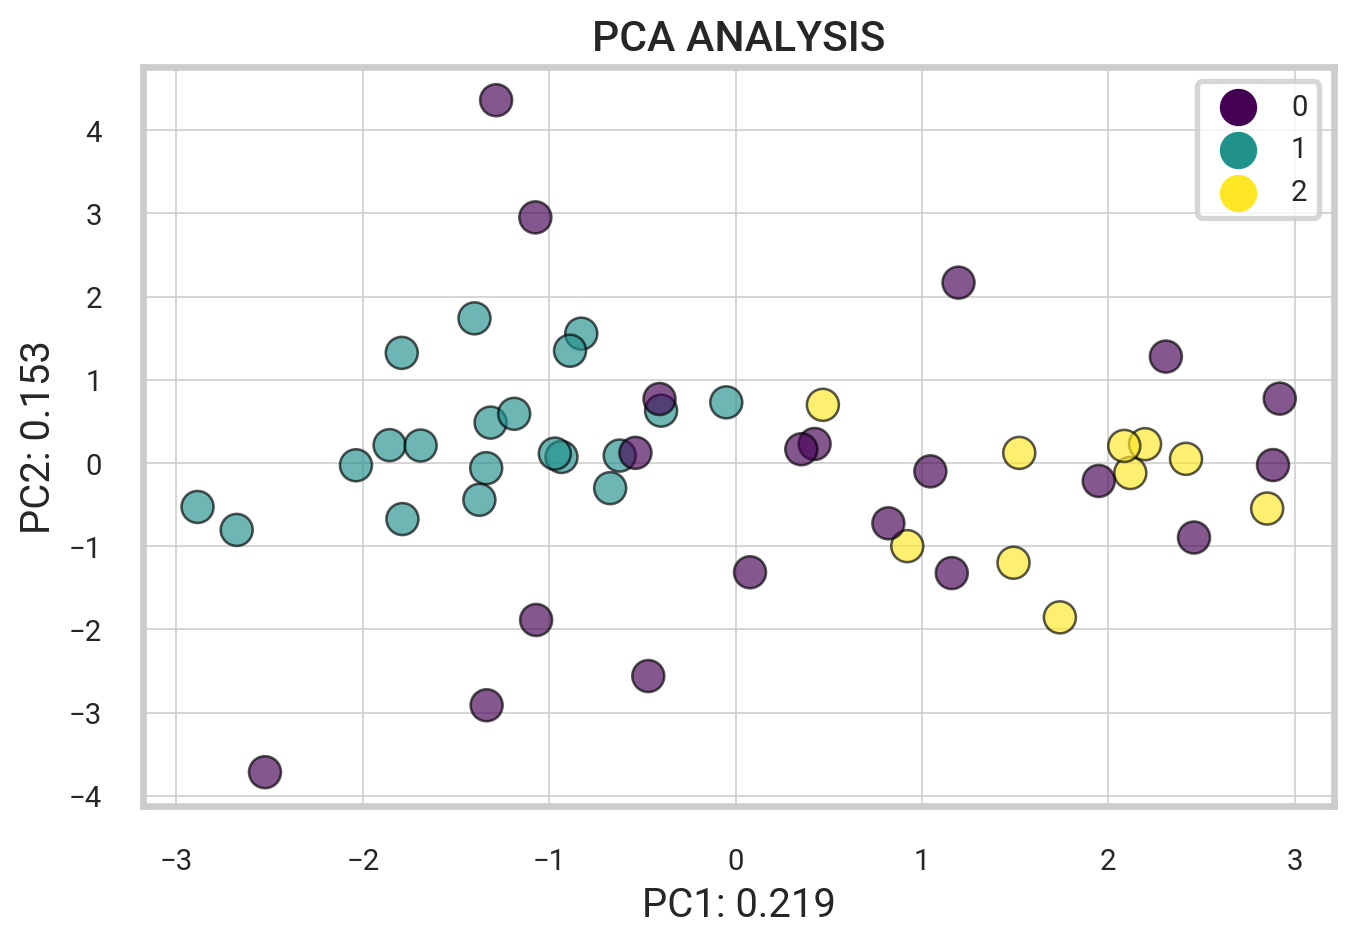

In [32]:
plot = sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue = list(kmeans.labels_),
                       alpha = 0.66, 
                       #size = data_pca[:,1], sizes = (50,200),
                       palette = 'viridis', edgecolor = 'black', cmap='Paired')
plot.set_title('PCA ANALYSIS', size = 16, weight='bold')

plt.xlabel('PC1: {:.3f}'.format(pca.explained_variance_ratio_[0]), size = 15)
plt.ylabel('PC2: {:.3f}'.format(pca.explained_variance_ratio_[1]), size = 15)


In [33]:
playlist_tracks['group'] = list(kmeans.labels_)
playlist_tracks = playlist_tracks.astype({'group': str})

means = pd.DataFrame(index = range(0,3), 
                    columns = list(playlist_tracks[playlist_tracks['group'] == '0'].describe().loc['mean'].index))
means.iloc[0] = playlist_tracks[playlist_tracks['group'] == '0'].describe().loc['mean']
means.iloc[1] = playlist_tracks[playlist_tracks['group'] == '1'].describe().loc['mean']
means.iloc[2] = playlist_tracks[playlist_tracks['group'] == '2'].describe().loc['mean']
means

,acousticness,danceability,energy,liveness,instrumentalness,speechiness,valence,sadness,joy,love,anger,fear
0,0.20839,0.672,0.60875,0.144285,0.020388,0.059735,0.54265,0.151202,0.108936,0.206101,0.253816,0.259347
1,0.126155,0.74595,0.67765,0.110685,0.017031,0.052625,0.6812,0.028329,0.854914,0.046817,0.0533,0.013642
2,0.3229,0.615,0.6254,0.13608,0.000763,0.0478,0.4399,0.893231,0.046527,0.002716,0.032235,0.023872


----------------------

#### Organized Songs in a Playlist


K-means is an unsupervised clustering algorithm that partitions data into $K$ clusters, grouping similar points together. Using Spotify data, we can cluster songs based on attributes like acousticness, danceability, and energy. We import Python libraries such as pandas, matplotlib, and sklearn for data manipulation, visualization, and clustering. After obtaining song attributes, we use the `describe` function to gain insights and prepare the data for clustering, as demonstrated below.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cluster, decomposition

songs = df_final[['name','acousticness', 'danceability', 'energy', 'instrumentalness', 
            'liveness', 'speechiness', 'valence',  'loudness_scaled', 
            'anger', 'love', 'sadness']]
songs.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,loudness_scaled,anger,love,sadness
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.198398,0.690180,0.639640,0.015120,0.129204,0.054504,0.577520,0.551367,0.129293,0.101710,0.250459
std,0.194310,0.144655,0.130139,0.059203,0.079672,0.032362,0.234215,0.221284,0.244960,0.245032,0.356076
min,0.000938,0.264000,0.386000,0.000000,0.029300,0.026400,0.190000,0.000000,0.000206,0.000193,0.001261
25%,0.040675,0.630500,0.552000,0.000000,0.082600,0.034775,0.373000,0.376041,0.002251,0.002018,0.007991
50%,0.140000,0.700500,0.635000,0.000003,0.106000,0.046450,0.591500,0.581936,0.026904,0.006858,0.041605
75%,0.270750,0.780000,0.727250,0.000082,0.139250,0.063300,0.775500,0.699484,0.124115,0.032315,0.401728
max,0.799000,0.936000,0.946000,0.336000,0.403000,0.204000,0.957000,1.000000,0.993250,0.994453,0.998848


The first step is to extract song labels from the dataset. We then select key features to input into the Affinity Propagation clustering algorithm from the *scikit-learn* library. We set a preference value of -200 to optimize clustering performance. After inputting the data, we train the algorithm to cluster the Spotify songs effectively.

In [35]:
labels = songs.values[:,0]
X = songs.values[:,1:12]
kmeans = cluster.AffinityPropagation()
kmeans.fit(X)

AffinityPropagation()

In [36]:
predictions = {}
for p,n in zip(kmeans.predict(X),labels):
    if not predictions.get(p):
        predictions[p] = []
        
    predictions[p] += [n]

for p in predictions:
    print("Category",p)
    print("-----")
    for n in predictions[p]:
        print(n)
    print("")

Category 0
-----
Please Please Please
Not Like Us
Beautiful Things
LUNCH
End of Beginning
Belong Together
Slow It Down
the boy is mine
360
Rockstar
One Of The Girls (with JENNIE, Lily Rose Depp)
Parking Lot
Gata Only
Santa
Magnetic

Category 1
-----
Si Antes Te Hubiera Conocido
Nasty
greedy
BAND4BAND (feat. Lil Baby)

Category 2
-----
BIRDS OF A FEATHER
we can't be friends (wait for your love)
Tough
Fortnight (feat. Post Malone)
Close To You
Stumblin' In
Scared To Start

Category 5
-----
Good Luck, Babe!
A Bar Song (Tipsy)
MILLION DOLLAR BABY
Too Sweet
I Had Some Help (Feat. Morgan Wallen)
Espresso
i like the way you kiss me
Houdini
I Don't Wanna Wait
Smeraldo Garden Marching Band (feat. Loco)
Water
Illusion

Category 3
-----
Stargazing
Lose Control
Austin
I Can Do It With a Broken Heart
GIRLS
Saturn
Stick Season
Lies Lies Lies
feelslikeimfallinginlove

Category 4
-----
HOT TO GO!
Move
28



The script effectively categorized the playlist into six distinct groups based on shared features, resulting in a diverse selection of songs within each category.

--------------

##  Supervised Learning: Similarity Search 



We create a query to retrieve [similar songs based on Euclidean distance](https://www.kaggle.com/code/leomauro/spotify-songs-similarity-search/notebook), where a shorter distance indicates greater similarity. Additionally, we employ the K-nearest neighbors (KNN) algorithm, a supervised learning method that classifies songs based on known data.



#### KNN Algorithm

> K-nearest neighbors (KNN) is a supervised algorithm for classification and regression. It predicts the category of new data points by comparing them to the K nearest neighbors with known classifications. For example, KNN can classify Spotify songs by analyzing their features and comparing them to similar, previously classified tracks.

The KNN algorithm identifies $k$ similar elements around a query point. Using the `knnQuery` function, we input a query point (a specific song and artist), characteristic points, and a value for $k$. This function calculates the Euclidean distance between the query point and each data point, returning the $k$ closest points.

The `querySimilars` function then applies KNN to find and return the $k$ most similar songs based on specified features.


In [37]:
# Get a song string search
def getMusicName(elem):
    return f"{elem['artist']} - {elem['name']}"

def knnQuery(queryPoint, arrCharactPoints, k):
    queryVals = queryPoint.tolist()
    distVals = []
    
    # Copy of data indices and data
    tmp = arrCharactPoints.copy(deep = True)  
    for index, row in tmp.iterrows():
        feat = row.values.tolist()
        
        # Calculate sum of squared differences
        ssd = sum(abs(feat[i] - queryVals[i]) ** 2 for i in range(len(queryVals)))
        
        # Get euclidean distance
        distVals.append(ssd ** 0.5)
        
    tmp['distance'] = distVals
    tmp = tmp.sort_values('distance')
    
    # K closest and furthest points
    return tmp.head(k).index, tmp.tail(k).index


# Execute KNN removing the query point
def querySimilar(df, columns, idx, func, param):
    arr = df[columns].copy(deep = True)
    queryPoint = arr.loc[idx]
    arr = arr.drop([idx])
    return func(queryPoint, arr, param)

**KNN Query Example.** 

Now we perform a KNN query to find the k most similar songs based on specified features. We first establish a function to generate custom query points. The code snippet below then selects specific song features and finds the top $k$ values within that feature set.


<!--Using the *sklearn* preprocessing library, we create a scaler to normalize features. Since all feature values range between 0 and 1, except for loudness, we scale loudness to fit within this range.-->

In [38]:
df = df_final

Let's search for  $k=3$  similar songs to a query point $\textrm{songIndex} = 6$. 

In [39]:
# Select song and column attributes
songIndex = 4 # query point
columns = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 
           'loudness_scaled', 'tempo', 
           'speechiness', 'valence']

# Set query parameters
func, param = knnQuery,3

# Implement query
response = querySimilar(df, columns, songIndex, func, param)

print("---- Query Point ----")
print(getMusicName(df.loc[songIndex]))
print('---- k = 3 similar songs ----')
for track_id in response[0]:
    track_name = getMusicName(df.loc[track_id])
    print(track_name)
print('---- k = 3 nonsimilar songs ----')
for track_id in response[1]:
    track_name = getMusicName(df.loc[track_id])
    print(track_name)

---- Query Point ----
Shaboozey - A Bar Song (Tipsy)
---- k = 3 similar songs ----
Morgan Wallen - Lies Lies Lies
Zach Bryan - 28
The Weeknd - One Of The Girls (with JENNIE, Lily Rose Depp)
---- k = 3 nonsimilar songs ----
SZA - Saturn
Benson Boone - Slow It Down
Taylor Swift - Fortnight (feat. Post Malone)



The code below extends the KNN algorithm to query each track in a playlist rather than a single defined query point.

To track the number of similar and non-similar songs, we use two dictionaries: `similar_count` and `nonsimilar_count`. A loop iterates through the playlist, running the `querySimilars` function on each track. The results are processed into "similar" and "non-similar" categories stored in the `response` variable. 



In [40]:
similar_count = {} # Similar songs count
nonsimilar_count = {} # Non-similar songs count

for track_index in df.index:
    # Implement query
    response = querySimilar(df, columns, track_index, func, param)
    
    # Get similar songs
    for similar_index in response[0]:
        track = getMusicName(df.loc[similar_index])
        if track in similar_count:
            similar_count[track] += 1
        else:
            similar_count[track] = 1
    
    # Get non-similar songs
    for nonsimilar_index in response[1]:
        track = getMusicName(df.loc[nonsimilar_index])
        if track in nonsimilar_count:
            nonsimilar_count[track] += 1
        else:
            nonsimilar_count[track] = 1

In [41]:
nonsimilar = dict(sorted(nonsimilar_count.items(), key=lambda item: item[1], reverse=True))
print('---- NON SIMILAR SONG COUNTS ----')
for track_name, track_count in nonsimilar.items():
    if track_count >= 8:
        print(track_name, ':', track_count)

similar = dict(sorted(similar_count.items(), key=lambda item: item[1], reverse=True))
print('\n---- SIMILAR SONG COUNTS ----')
for track_name, track_count in similar.items():
    if track_count >= 5:
        print(track_name, ':', track_count)

---- NON SIMILAR SONG COUNTS ----
Benson Boone - Slow It Down : 39
Taylor Swift - Fortnight (feat. Post Malone) : 39
SZA - Saturn : 36
Zach Bryan - 28 : 14
Morgan Wallen - Lies Lies Lies : 11
Shaboozey - A Bar Song (Tipsy) : 11

---- SIMILAR SONG COUNTS ----
Rvssian - Santa : 6
Dua Lipa - Illusion : 5
Hozier - Too Sweet : 5
The Weeknd - One Of The Girls (with JENNIE, Lily Rose Depp) : 5
Mustard - Parking Lot : 5
Tinashe - Nasty : 5
Chappell Roan - Good Luck, Babe! : 5
Djo - End of Beginning : 5


------------------------------------------